# import libraries

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyaw import utils
from pyaw.swarm import save_SW_EFIx_TCT16, save_SW_MAGx_HR_1B

# %load_ext watermark: Loads the watermark extension, which is a Jupyter magic command to display metadata about your environment.
#
# %watermark -i -v -p viresclient,pandas,matplotlib:
#
# -i: Displays information about the current Python interpreter.
# -v: Displays the Python version being used.
# -p viresclient,pandas,matplotlib: Displays the versions of the specified packages (viresclient, pandas, and matplotlib).
%load_ext watermark
%watermark -i -v -p numpy,pandas,scipy,matplotlib,viresclient
# 逗号之间有空格会报错

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.27.0

numpy      : 1.25.2
pandas     : 2.2.2
scipy      : 1.13.1
matplotlib : 3.8.0
viresclient: 0.12.0



# basic assignment of variables

In [4]:
start_time_analytical = '20160311T064700'
end_time_analytical = '20160311T064900'
# QA:: extend one window time (in this reproduction, the window time will be 20 seconds)
start_time_save = '20160311T064640'
end_time_save = '20160311T064920'
satellite = 'A'
sdir = Path("./data")
sfn_EFIA_TCT16 = Path("EFIA_TCT16_20160311T064640_20160311T064920.pkl")
sfn_MAGA_HR_1B = Path("MAGA_HR_1B_20160311T064640_20160311T064920.pkl")
fs_e = 16
fs_b = 50

# download data

In [5]:
save_SW_EFIx_TCT16(start_time_save, end_time_save, satellite, sdir,
                   sfn_EFIA_TCT16)
save_SW_MAGx_HR_1B(start_time_save, end_time_save, satellite, sdir,
                   sfn_MAGA_HR_1B)

data\EFIA_TCT16_20160311T064640_20160311T064920.pkl already exists, skip save.
data\MAGA_HR_1B_20160311T064640_20160311T064920.pkl already exists, skip save.


# read data

In [6]:
df_e = pd.read_pickle(Path(sdir) / Path(sfn_EFIA_TCT16))
df_b = pd.read_pickle(Path(sdir) / Path(sfn_MAGA_HR_1B))
timestamps_e = df_e.index.values
timestamps_b = df_b.index.values
del sdir, sfn_EFIA_TCT16, sfn_MAGA_HR_1B

# magnetic field in NEC coordinate system

In [7]:
bn, be, bc = utils.get_3arrs(df_b['B_NEC'].values)

## plot

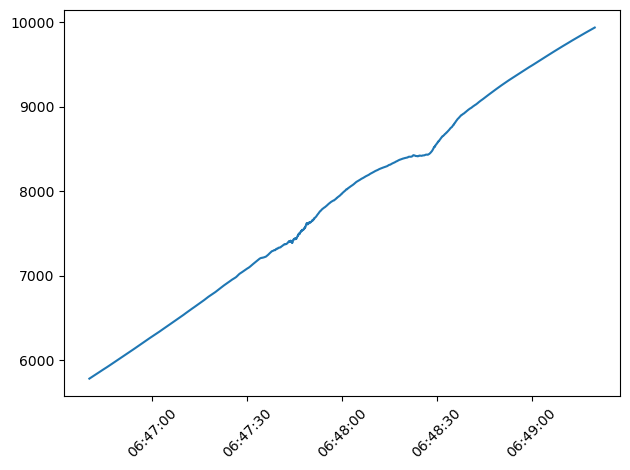

In [8]:
plt.plot(timestamps_b, bn)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

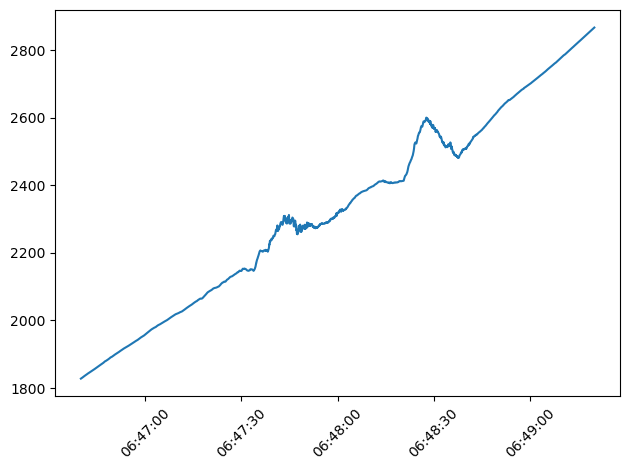

In [9]:
plt.plot(timestamps_b, be)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

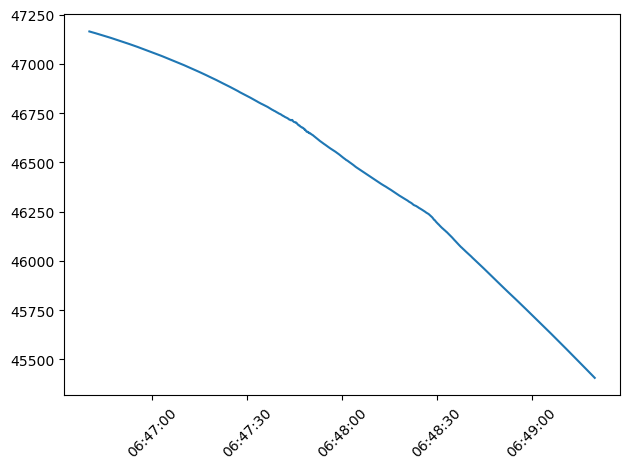

In [10]:
plt.plot(timestamps_b, bc)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# electric field in NEC coordinate system

## electric field in satellite-track coordinate system

In [11]:
Ehx = df_e['Ehx'].values
Ehy = df_e['Ehy'].values

## coordinate transformation from satellite-track coordinate system to NEC coordinate system

In [12]:
VsatN = df_e['VsatN'].values
VsatE = df_e['VsatE'].values
rotation_matrix_2d_nec2sc, rotation_matrix_2d_sc2nec = utils.get_rotmat_nec2sc_sc2nec(VsatN, VsatE)

### preprocess before rotation

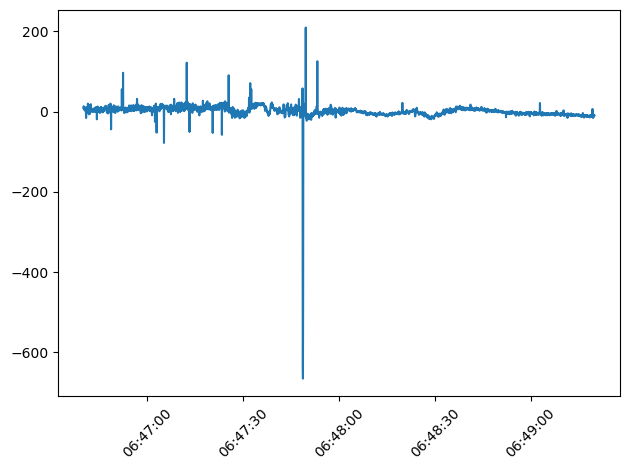

In [13]:
plt.plot(timestamps_e, Ehx)
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures everything fits within the figure
plt.show()

In [14]:
np.std(Ehx), np.mean(Ehx), np.max(Ehx), np.min(Ehx)

(23.041916, 1.0366622, 209.64946, -665.1797)

In [15]:
Ehx_set_outliers_nan = utils.set_outliers_nan_std(Ehx, print_=True)
Ehy_set_outliers_nan = utils.set_outliers_nan_std(Ehy, print_=True)

30
[ -43.9735     55.85131    96.95131    31.929352  -25.18946   -52.246895
  -77.74769    32.06451   122.04997    24.538439  -50.420204   27.311708
   25.95723   -52.979156  -57.540714   24.142708   25.899548   90.70911
   35.12801    71.15288    56.372738   31.657372   27.904247   58.08169
 -630.02313  -665.1797   -455.31207   209.64946   -22.509426  125.68604 ]
33
[  64.18146    69.17008    68.854675   67.748085   72.29167    63.576897
   71.010735   70.199295   79.56611    62.859295   72.29569    68.10827
   68.18476    65.32831    85.93454    71.88532    65.98927    62.882183
   71.72013    65.072205   68.92534    64.02373    63.6884     63.51877
   71.33222   -65.169945 1116.1362   1207.5975    117.2339     88.194145
   63.17441   -23.732807   -8.277935]


In [16]:
Ehx_set_outliers_nan_interpolated = utils.get_array_interpolated(timestamps_e, Ehx_set_outliers_nan)
Ehy_set_outliers_nan_interpolated = utils.get_array_interpolated(timestamps_e, Ehy_set_outliers_nan)

### do rotation

In [17]:
Ehn, Ehe = utils.do_rotation(-Ehx_set_outliers_nan_interpolated, -Ehy_set_outliers_nan_interpolated,
                             rotation_matrix_2d_sc2nec)
# note:: I add the negative sign to the x,y components of the electric field in the satellite-track coordinate system.

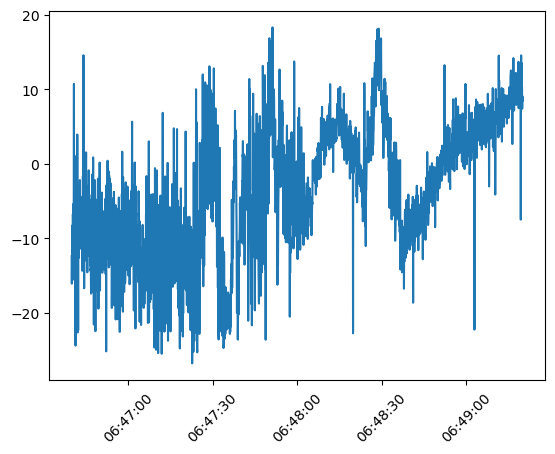

In [18]:
plt.plot(timestamps_e, Ehn)
plt.xticks(rotation=45)
plt.show()

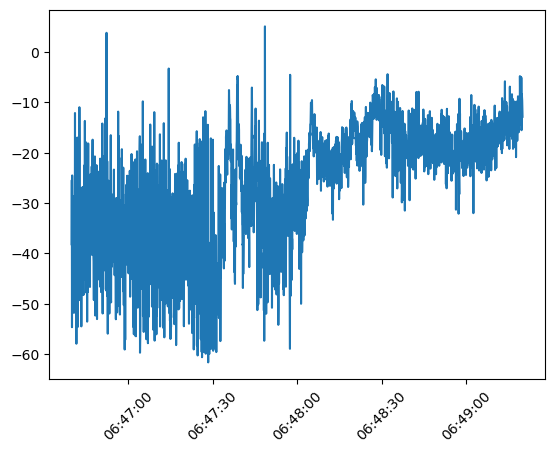

In [19]:
plt.plot(timestamps_e, Ehe)
plt.xticks(rotation=45)
plt.show()

# E north and B east

## original E and B

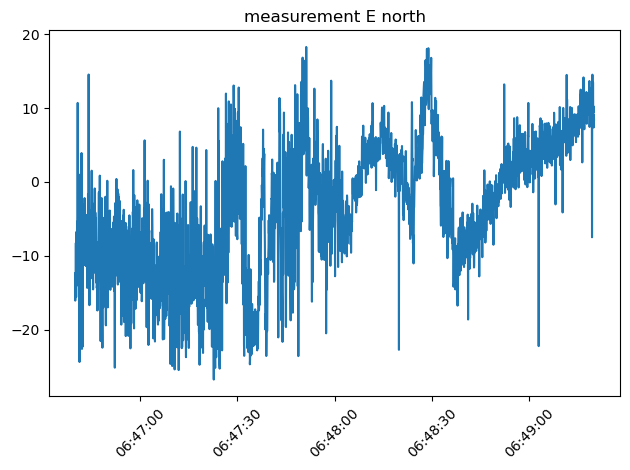

In [20]:
plt.plot(timestamps_e, Ehn)
plt.title("measurement E north")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

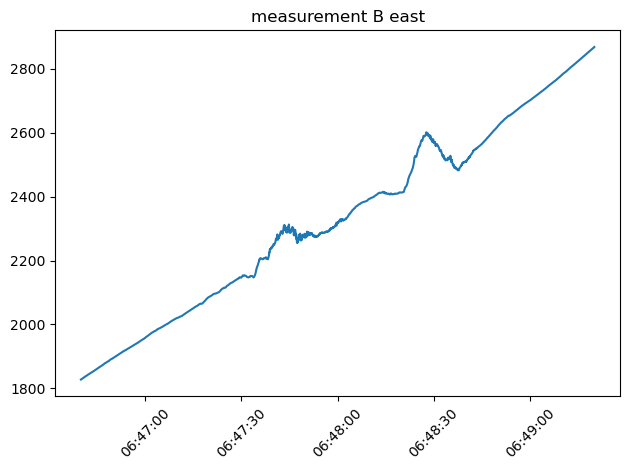

In [21]:
plt.plot(timestamps_b, be)
plt.title("measurement B east")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## move average

In [22]:
mv_window_seconds = 20  # int
window_e = fs_e * mv_window_seconds
Ehn_mov_ave = utils.move_average(Ehn, window_e)

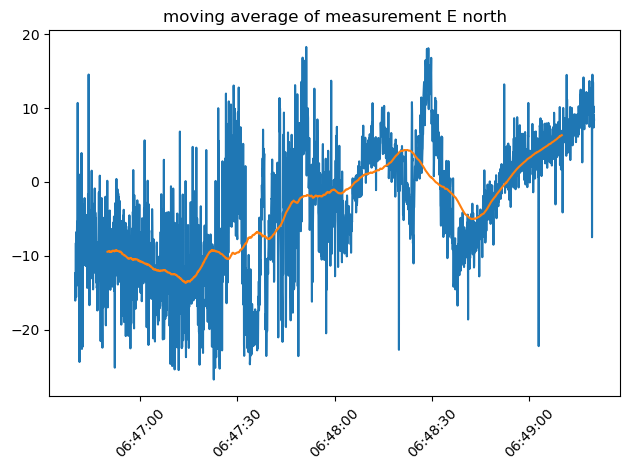

In [23]:
plt.plot(timestamps_e, Ehn)
plt.plot(timestamps_e, Ehn_mov_ave)
plt.title("moving average of measurement E north")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
window_b = fs_b * mv_window_seconds
be_mov_ave = utils.move_average(be, window_b)

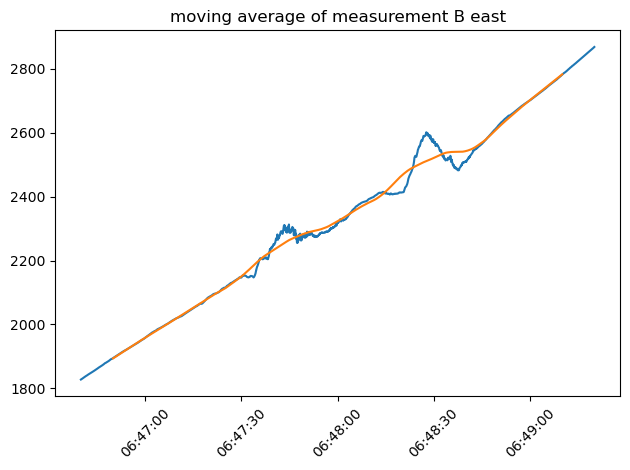

In [25]:
# plt.figure()
plt.plot(timestamps_b, be)
plt.plot(timestamps_b, be_mov_ave)
plt.title("moving average of measurement B east")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig(f'before and after moving average comparison')

## disturb field

delete the moving average of the field

In [26]:
Ehn_disturb = Ehn - Ehn_mov_ave
be_disturb = be - be_mov_ave

#### use analytical time to slice the disturb field

In [27]:
mask_e = np.where((timestamps_e >= utils.convert_tstr2dt64(start_time_analytical)) & (
            timestamps_e <= utils.convert_tstr2dt64(
        end_time_analytical)))  # mask for analytical time
mask_e

(array([ 320,  321,  322, ..., 2237, 2238, 2239], dtype=int64),)

In [28]:
timestamps_e_analytical = timestamps_e[mask_e]
Ehn_disturb_analytical = Ehn_disturb[mask_e]

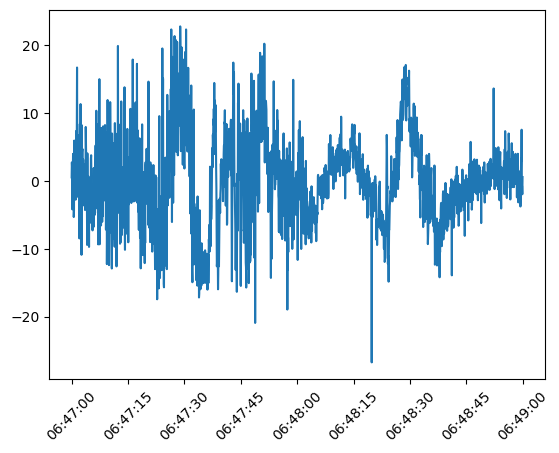

In [29]:
plt.plot(timestamps_e_analytical, Ehn_disturb_analytical)
plt.xticks(rotation=45)
plt.show()

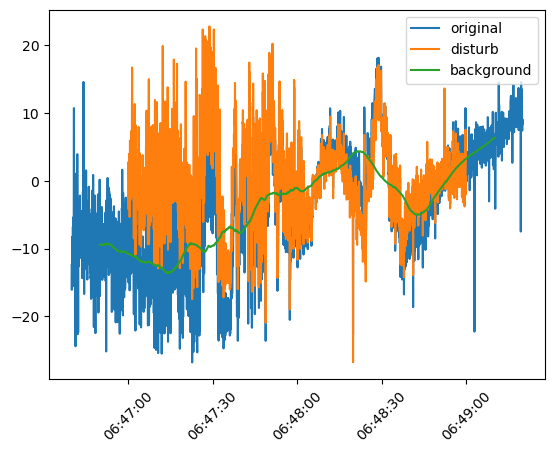

In [30]:
# original electric field and disturb electric field and background electric filed
plt.plot(timestamps_e, Ehn, label='original')
plt.plot(timestamps_e_analytical, Ehn_disturb_analytical, label='disturb')
plt.plot(timestamps_e, Ehn_mov_ave, label='background')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [31]:
mask_b = np.where((timestamps_b >= utils.convert_tstr2dt64(start_time_analytical)) & (
            timestamps_b <= utils.convert_tstr2dt64(
        end_time_analytical)))  # mask for analytical time
mask_b

(array([1000, 1001, 1002, ..., 6997, 6998, 6999], dtype=int64),)

In [32]:
timestamps_b_analytical = timestamps_b[mask_b]
be_disturb_analytical = be_disturb[mask_b]

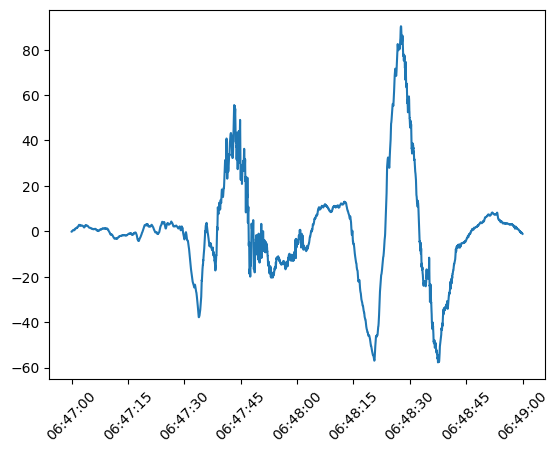

In [33]:
plt.plot(timestamps_b_analytical, be_disturb_analytical)
plt.xticks(rotation=45)
plt.show()

## filter

In [34]:
butter_e = utils.Butter(Ehn_disturb_analytical, fs_e)
butter_b = utils.Butter(be_disturb_analytical, fs_b)
# IIR filter
lowcut = 0.2
highcut = 4
order = 5
# get filter data
Ehn_disturb_analytical_filtered = butter_e.apply_bandpass_filter(lowcut, highcut, order)
be_disturb_analytical_filtered = butter_b.apply_bandpass_filter(lowcut, highcut, order)

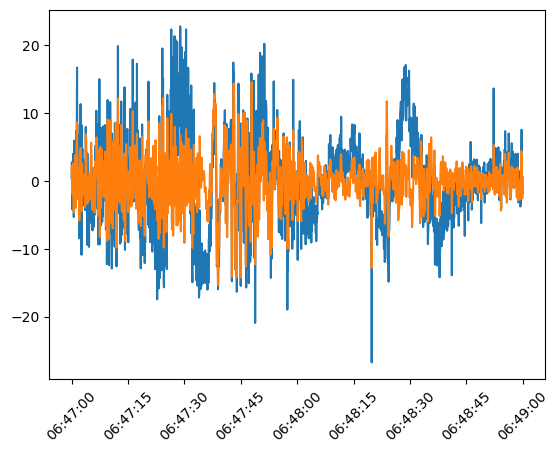

In [35]:
plt.plot(timestamps_e_analytical, Ehn_disturb_analytical)
plt.plot(timestamps_e_analytical, Ehn_disturb_analytical_filtered)
plt.xticks(rotation=45)
plt.show()

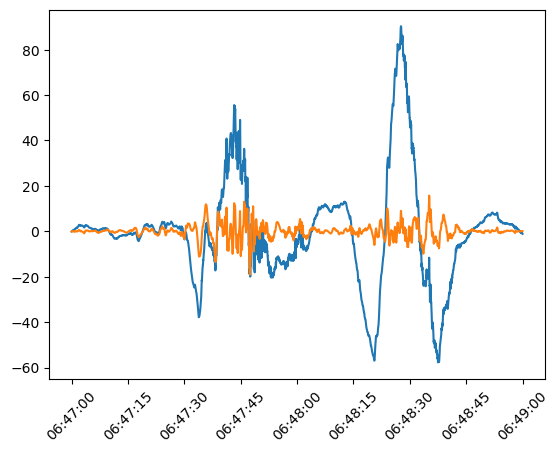

In [36]:
plt.plot(timestamps_b_analytical, be_disturb_analytical)
plt.plot(timestamps_b_analytical, be_disturb_analytical_filtered)
plt.xticks(rotation=45)
plt.show()

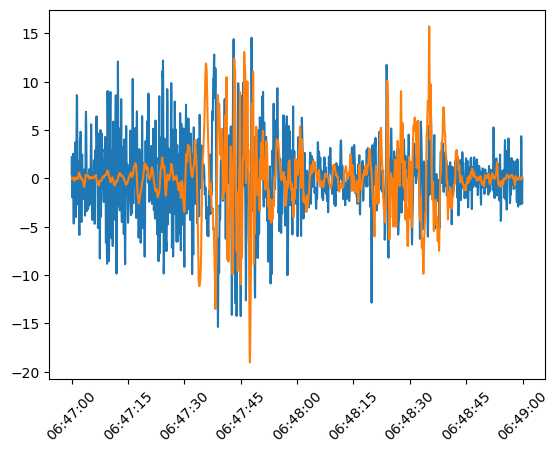

In [37]:
plt.plot(timestamps_e_analytical, Ehn_disturb_analytical_filtered)
plt.plot(timestamps_b_analytical, be_disturb_analytical_filtered)
plt.xticks(rotation=45)
plt.show()

## STFT

short-time Fourier transform

In [38]:
from scipy.signal import stft

# stft (spectral) basic parameters
window = 'hann'
stft_window_seconds = 4  # second
nperseg_e = int(stft_window_seconds * fs_e)  # 每个窗的采样点数
noverlap_e = nperseg_e // 2  # 50%重叠
nperseg_b = int(stft_window_seconds * fs_b)
noverlap_b = nperseg_b // 2

# get stft
f_e, t_e, Zxx_e = stft(Ehn_disturb_analytical, fs_e, window=window, nperseg=nperseg_e, noverlap=noverlap_e,
                       scaling='psd')
f_b, t_b, Zxx_b = stft(be_disturb_analytical, fs_b, window=window, nperseg=nperseg_b, noverlap=noverlap_b,
                       scaling='psd')

In [39]:
t_e_dt64 = timestamps_e_analytical[0] + [np.timedelta64(int(_), 's') for _ in t_e]
t_b_dt64 = timestamps_b_analytical[0] + [np.timedelta64(int(_), 's') for _ in t_b]

### module

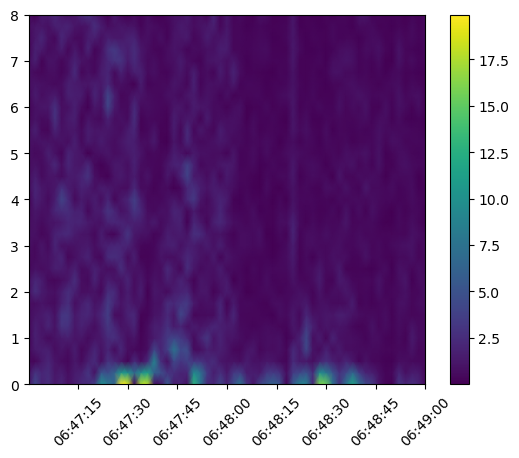

In [40]:
plt.pcolormesh(t_e_dt64, f_e, np.abs(Zxx_e), shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

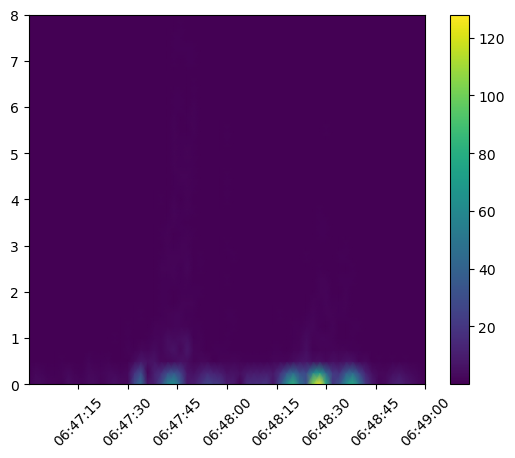

In [41]:
plt.pcolormesh(t_b_dt64, f_b, np.abs(Zxx_b), shading='gouraud')
plt.ylim([0, 8])
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

### cross spectral

In [42]:
mask_f_b = np.where(f_b <= 8.0)
mask_f_b

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
       dtype=int64),)

In [43]:
f_b_mask = f_b[mask_f_b]
f_b_mask, f_e

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
        5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
        5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ]))

In [44]:
Zxx_b_mask = Zxx_b[mask_f_b]
Zxx_b_mask.shape

(33, 61)

In [45]:
# confirm
np.all(t_e == t_b), np.all(t_e_dt64 == t_b_dt64), np.all(f_e == f_b_mask), Zxx_b_mask.shape == Zxx_e.shape
# note:: because the fs between b and e is different, so the start time of b and e is fine different

(True, False, True, True)

In [46]:
cross_e_b_spectral_density = Zxx_e * np.conj(Zxx_b_mask)

#### module

In [47]:
cross_e_b_spectral_density_module = np.abs(cross_e_b_spectral_density)
np.min(cross_e_b_spectral_density_module), np.max(cross_e_b_spectral_density_module), np.percentile(
    cross_e_b_spectral_density_module, 95)

(3.4459414148942276e-05, 2056.7596666950794, 9.607242127605579)

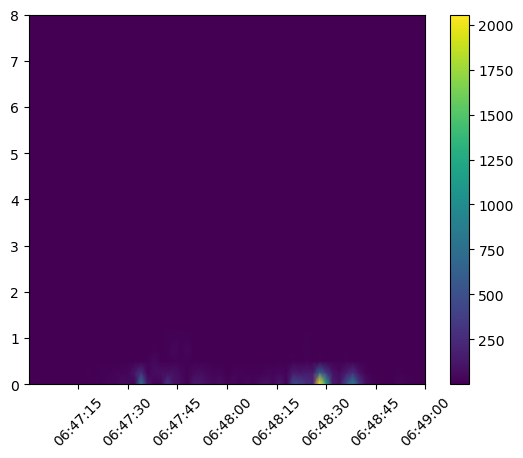

In [48]:
plt.pcolormesh(t_e_dt64, f_e, cross_e_b_spectral_density_module, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

##### process the outliers

In [49]:
threshold = np.percentile(cross_e_b_spectral_density_module, 95)  # note:: use 95% percentile not the maximum value
# set_value = np.min(cross_e_b_spectral_density_module)
# set_value = np.max(cross_e_b_spectral_density_module)
set_value = threshold
# note:: 设置为threshold更合理，同时这样设置后面的相位差绘制也更合理。可以设置为最小值或0来对比设置为threshold

modified_cross_e_b_spectral_density_module = utils.threshold_and_set(cross_e_b_spectral_density_module.copy(),
                                                                     threshold,
                                                                     set_value)  # Use .copy() to avoid in-place modification

In [50]:
np.min(modified_cross_e_b_spectral_density_module), np.max(modified_cross_e_b_spectral_density_module)

(3.4459414148942276e-05, 9.607242127605579)

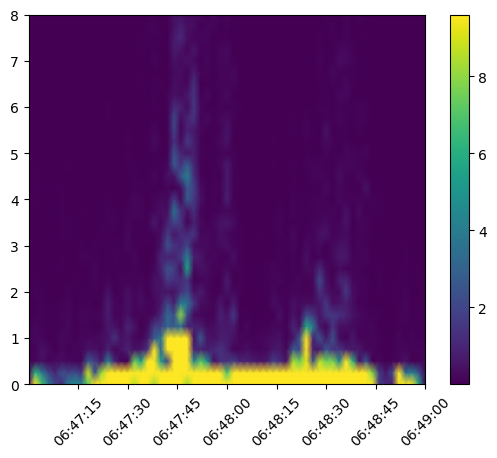

In [51]:
plt.pcolormesh(t_e_dt64, f_e, modified_cross_e_b_spectral_density_module, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

##### normalized

In [52]:
modified_cross_e_b_spectral_density_module_normalized = utils.normalize_to_01(
    modified_cross_e_b_spectral_density_module)
np.min(modified_cross_e_b_spectral_density_module_normalized), np.max(
    modified_cross_e_b_spectral_density_module_normalized), np.percentile(
    modified_cross_e_b_spectral_density_module_normalized, 50)

(0.0, 1.0, 0.0045535813954491414)

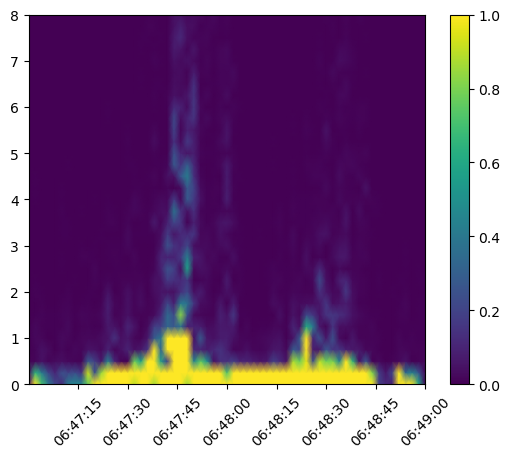

In [53]:
plt.pcolormesh(t_e_dt64, f_e, modified_cross_e_b_spectral_density_module_normalized, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

#### phase

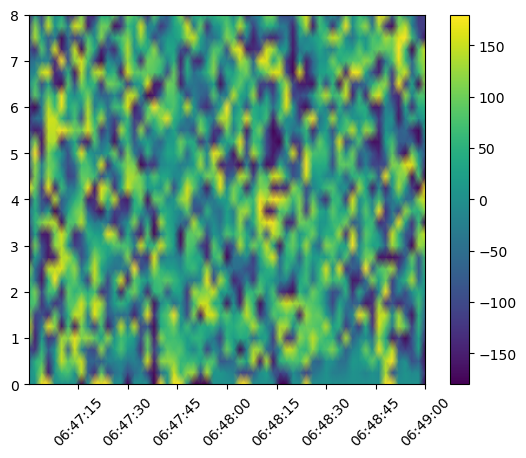

In [54]:
cross_e_b_spectral_density_phase = np.degrees(np.angle(cross_e_b_spectral_density))
plt.pcolormesh(t_e_dt64, f_e, cross_e_b_spectral_density_phase, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()  # 交叉谱中很多由于数据本身的噪声的影响，导致相位图像没有规律

##### phase with threshold

In [55]:
cross_e_b_spectral_density_phase_mask = cross_e_b_spectral_density_phase.copy()
cross_e_b_spectral_density_phase_mask[modified_cross_e_b_spectral_density_module_normalized < 0.003] = np.nan
# note:: the threshold is set to 0.003 according to the 50 percentile of the normalized cross spectral density module
# note:: 也许不用

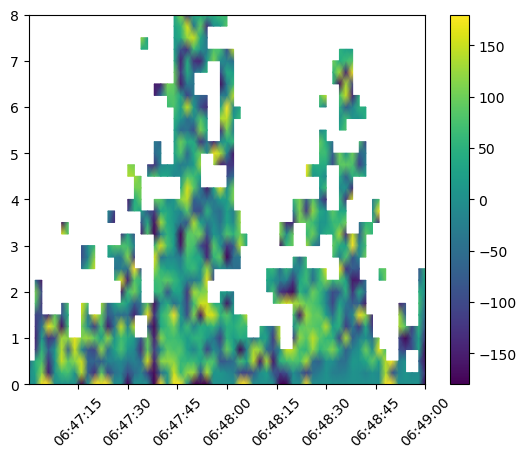

In [56]:
plt.pcolormesh(t_e_dt64, f_e, cross_e_b_spectral_density_phase_mask, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

# regions

In [57]:
mu0 = 4 * np.pi * 1e-7  # 真空磁导率 （维基）
Sigma_P_quiet = 0.5
Sigma_P_auroral = 3.0
va_quiet=1.3e6
va_auroral=1.4e6

## auroral region

### disturd: e vs b; disturb_filterd: e vs b

In [58]:
start_time_auroral = np.datetime64('2016-03-11T06:47:35', 'ns')
region_end_time_auroral = np.datetime64('2016-03-11T06:47:55',
                                        'ns')  # note:: the time of auroral region is 20 seconds, that is the same as the moving average window time

In [59]:
mask_e_auroral = (timestamps_e_analytical >= start_time_auroral) & (
        timestamps_e_analytical <= region_end_time_auroral)
mask_e_auroral

array([False, False, False, ..., False, False, False])

In [60]:
timestamps_e_auroral = timestamps_e_analytical[mask_e_auroral]
Ehn_disturb_auroral = Ehn_disturb_analytical[mask_e_auroral]
Ehn_disturb_filterd_auroral = Ehn_disturb_analytical_filtered[mask_e_auroral]

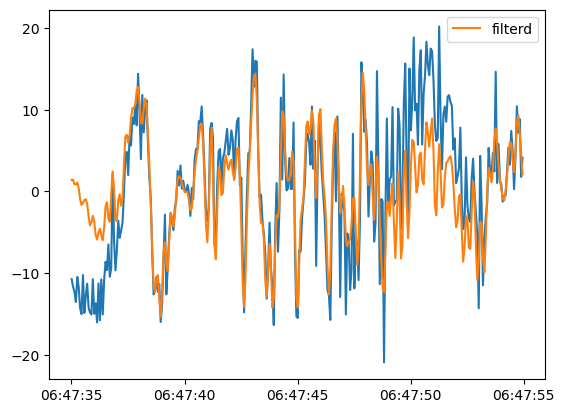

In [61]:
plt.plot(timestamps_e_auroral, Ehn_disturb_auroral)
plt.plot(timestamps_e_auroral, Ehn_disturb_filterd_auroral, label='filterd')
plt.legend()
plt.show()

In [62]:
mask_b_auroral = (timestamps_b_analytical >= start_time_auroral) & (
        timestamps_b_analytical <= region_end_time_auroral)
mask_b_auroral

array([False, False, False, ..., False, False, False])

In [63]:
timestamps_b_auroral = timestamps_b_analytical[mask_b_auroral]
be_disturb_auroral = be_disturb_analytical[mask_b_auroral]
be_disturb_filterd_auroral = be_disturb_analytical_filtered[mask_b_auroral]

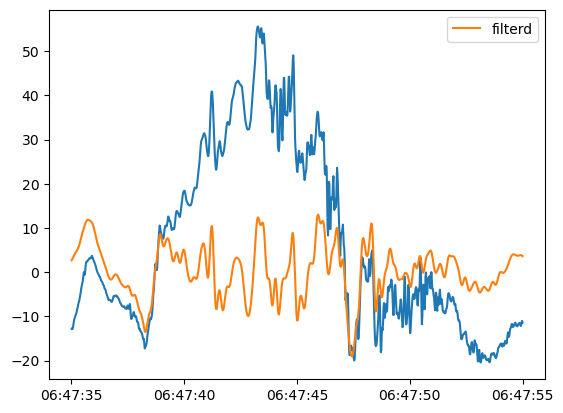

In [64]:
plt.plot(timestamps_b_auroral, be_disturb_auroral)
plt.plot(timestamps_b_auroral, be_disturb_filterd_auroral, label='filterd')
plt.legend()
plt.show()

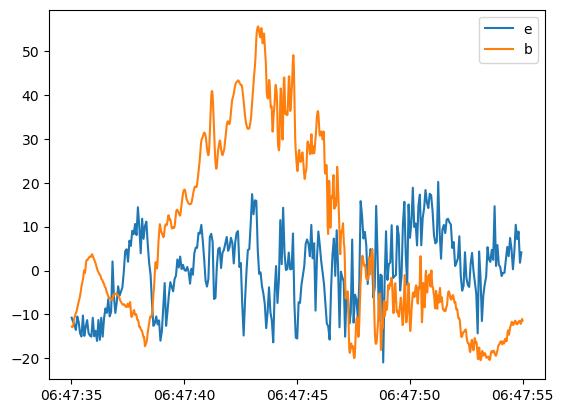

In [65]:
plt.plot(timestamps_e_auroral, Ehn_disturb_auroral, label='e')
plt.plot(timestamps_b_auroral, be_disturb_auroral, label='b')
plt.legend()
plt.show()

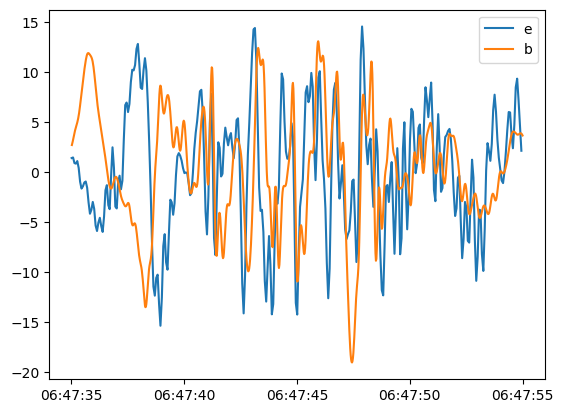

In [66]:
plt.plot(timestamps_e_auroral, Ehn_disturb_filterd_auroral, label='e')
plt.plot(timestamps_b_auroral, be_disturb_filterd_auroral, label='b')
plt.legend()
plt.show()

### stft -> ratio

In [67]:
mask_stft_auroral = (t_b_dt64 >= start_time_auroral) & (t_b_dt64 <= region_end_time_auroral)
mask_stft_auroral

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [68]:
auroral_t_b_dt64 = t_b_dt64[mask_stft_auroral]
auroral_Zxx_b = Zxx_b_mask[:, mask_stft_auroral]

auroral_t_e_dt64 = t_e_dt64[mask_stft_auroral]
auroral_Zxx_e = Zxx_e[:, mask_stft_auroral]

In [69]:
auroral_e_b_ratio = np.abs(auroral_Zxx_e) / np.abs(auroral_Zxx_b)
np.max(auroral_e_b_ratio), np.min(auroral_e_b_ratio), np.percentile(auroral_e_b_ratio, 95)  # QA:: 一个异常值（最大值）

(2826.2025486242374, 0.025330805068584827, 16.268193122220392)

In [70]:
threshold = np.percentile(auroral_e_b_ratio, 95)
set_value = threshold
modified_auroral_e_b_ratio = utils.threshold_and_set(auroral_e_b_ratio.copy(), threshold, set_value)

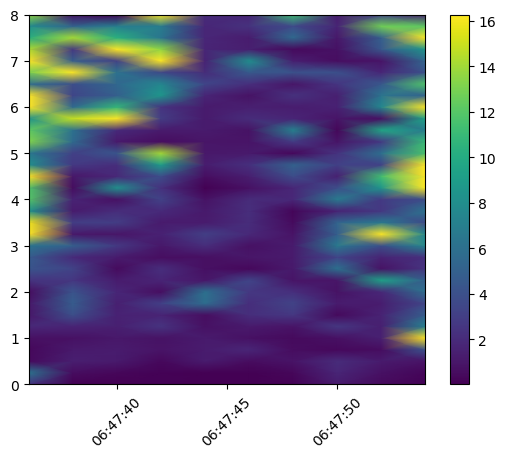

In [71]:
plt.pcolormesh(auroral_t_e_dt64, f_e, modified_auroral_e_b_ratio, shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### counts

In [72]:
np.min(modified_auroral_e_b_ratio), np.max(modified_auroral_e_b_ratio), np.percentile(modified_auroral_e_b_ratio,
                                                                                      50), np.percentile(
    modified_auroral_e_b_ratio, 95)

(0.025330805068584827,
 16.268193122220392,
 2.1225605344966265,
 16.10635589265272)

In [73]:
# ratio_bins = np.linspace(0,np.max(modified_auroral_e_b_ratio),num)
# note:: not use above code to generate the bins, because don't know how to set a reasonable 'num'. 如果num设置小了，对于quiet的ratio来说，可能由于部分的大值导致bins的宽度过大，从而导致计数不合理

In [74]:
auroral_ratio_bins = np.arange(0, np.max(modified_auroral_e_b_ratio) + 2, 0.2)  # 值的跨度根据不同的范围可以设置不同的值，这里范围小，所以设置的值小。
auroral_ratio_bins

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
        4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
        6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
        8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
       11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. ,
       13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2,
       15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4,
       17.6, 17.8, 18. , 18.2])

In [75]:
auroral_ratio_hist_counts = utils.get_ratio_histogram2d(f_e, modified_auroral_e_b_ratio, auroral_ratio_bins)

# hist_counts = np.zeros((len(f_e),len(auroral_ratio_bins)-1))
# for i,_ in enumerate(f_e):
#     hist_counts[i],_ = np.histogram(modified_auroral_e_b_ratio[i],bins=auroral_ratio_bins)

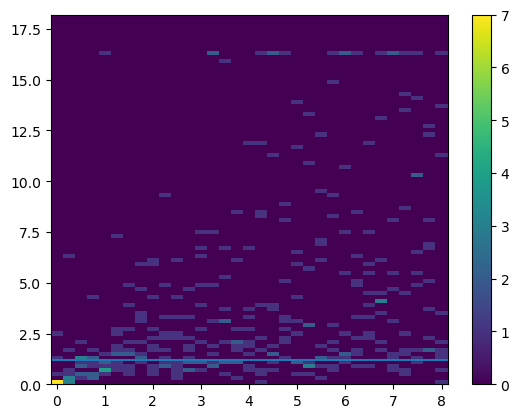

In [76]:
plt.pcolormesh(f_e, (auroral_ratio_bins[:-1] + auroral_ratio_bins[1:]) / 2, auroral_ratio_hist_counts.T)
plt.axhline(1.2)
plt.colorbar()
plt.show()  # todo:: 一个频率带内的比值的均值（类似fft中没有时间轴？）

### phase difference

with threshold

In [77]:
auroral_cross_e_b_spectral_density_phase_mask = cross_e_b_spectral_density_phase_mask[:, mask_stft_auroral]

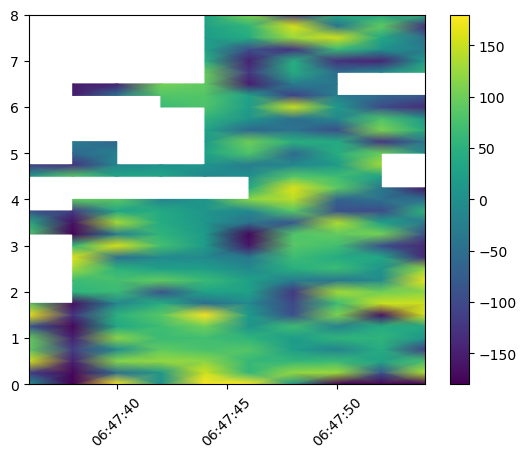

In [78]:
plt.pcolormesh(auroral_t_e_dt64, f_e, auroral_cross_e_b_spectral_density_phase_mask, shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### phase counts

In [79]:
num_bins = 50
phase_diff_bins, auroral_phase_diff_hist_counts = utils.get_phase_histogram2d(f_e,
                                                                              auroral_cross_e_b_spectral_density_phase_mask,
                                                                              num_bins=num_bins)

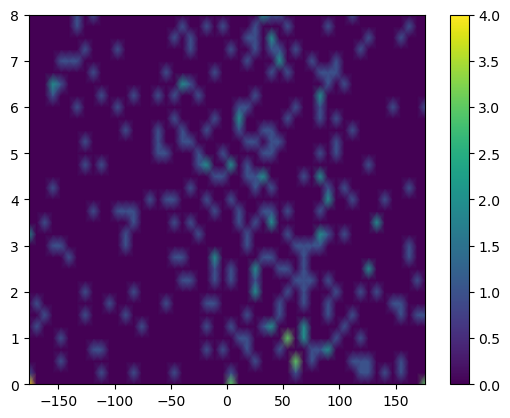

In [80]:
plt.pcolormesh((phase_diff_bins[:-1] + phase_diff_bins[1:]) / 2, f_e, auroral_phase_diff_hist_counts, shading='gouraud')
plt.colorbar()
plt.show()  # 看不出明显的规律。同quiet区域对比而言有一点区别，但也看不出。
# todo:: 使用 CWT 试试

### spectral without time axis

#### fft

In [81]:
auroral_Ehn_disturb_fft = utils.FFT(Ehn_disturb_auroral, fs_e)

In [82]:
auroral_Ehn_disturb_fft.get_fft()

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
        3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
        3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35,
        4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 ,
        4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35, 5.4 , 5.45,
        5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 , 5.95, 6.  ,
        6.05, 6.1 , 6.15, 6.2 , 6.25, 6.3 , 6.35, 6.4 , 6.45, 6.5 , 6.55,
        6.6 , 6.65, 6.7 , 6.75, 6.8 , 6.85, 6.9 , 6.95, 7.  , 7.05, 7.1 ,
        7.15, 7.2 , 7.25, 7.3 , 7.35, 

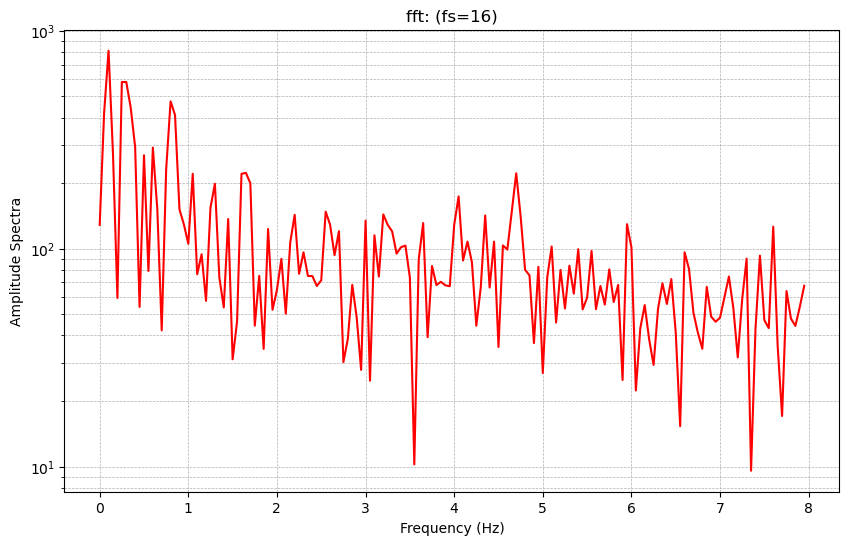

In [83]:
auroral_Ehn_disturb_fft.plot_fft()
plt.show()

In [84]:
auroral_be_disturb_fft = utils.FFT(be_disturb_auroral, fs_b)

In [85]:
auroral_be_disturb_fft.get_fft()

(array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
         1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
         1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
         2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
         2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
         3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
         3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
         4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
         4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
         4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
         5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
         5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,
      

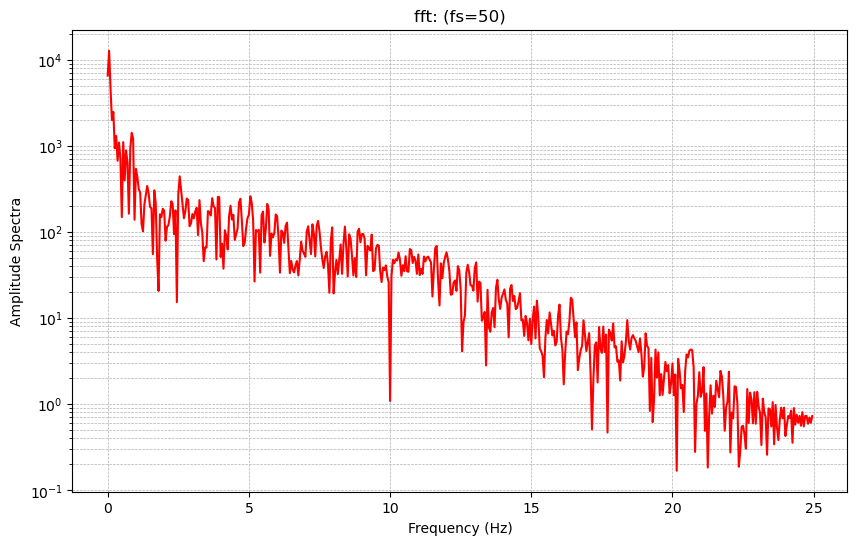

In [86]:
auroral_be_disturb_fft.plot_fft()
plt.show()

In [87]:
# one figure
freqs_e, amps_e, _ = auroral_Ehn_disturb_fft.get_fft()
freqs_b, amps_b, _ = auroral_be_disturb_fft.get_fft()
mask_b_fft = freqs_b < 8
freqs_b_mask = freqs_b[mask_b_fft]
amps_b_mask = amps_b[mask_b_fft]
np.all(freqs_e == freqs_b_mask)  # todo:: 相等意味着后续可以直接求比值。频率数组的取值间隔=$fs_e / len(e)$。此处可能有待优化。

True

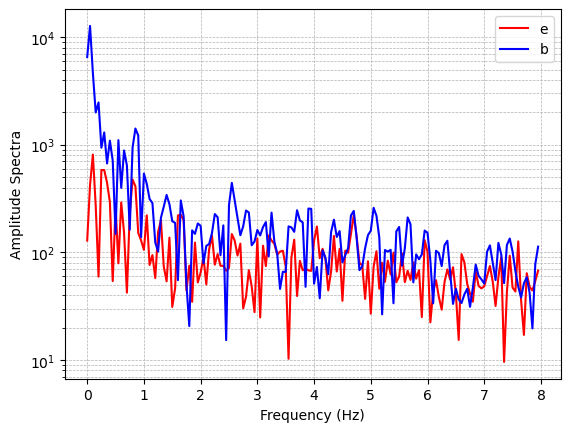

In [88]:
plt.plot(freqs_e, amps_e, color='red', label='e')
plt.plot(freqs_b_mask, amps_b_mask, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

##### ratio

In [89]:
eb_ratio_fft = amps_e / amps_b_mask
eb_ratio_fft_SI = eb_ratio_fft * 1e-3 * 1e9

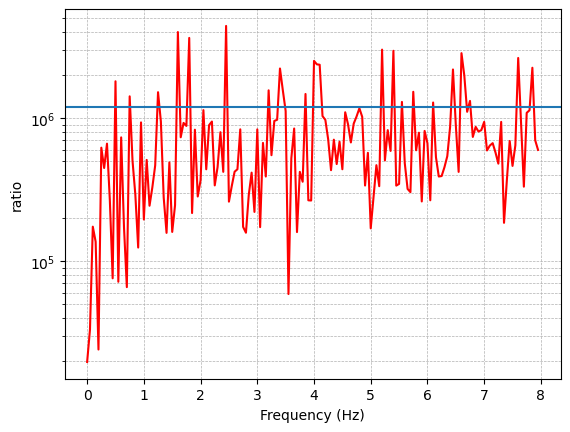

In [90]:
plt.plot(freqs_e, eb_ratio_fft_SI, color='red', label='e')
plt.axhline(1.2e6)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

#### psd

scipy.signal.welch()

返回的频率数组由输入的数组采样率、采用的nperseg,noverlap,return_onesided决定。应该能够通过这些返回一样的频率数组

In [91]:
from scipy.signal import welch

# psd
freqs_e_psd_density, auroral_Ehn_disturb_psd_density = welch(Ehn_disturb_auroral, fs_e, scaling='density')

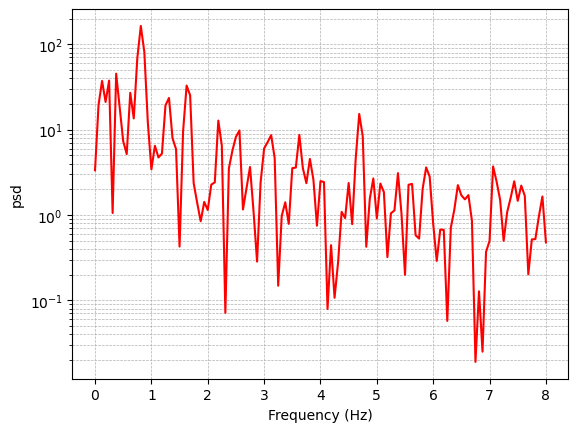

In [92]:
plt.plot(freqs_e_psd_density, auroral_Ehn_disturb_psd_density, color='red')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('psd')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

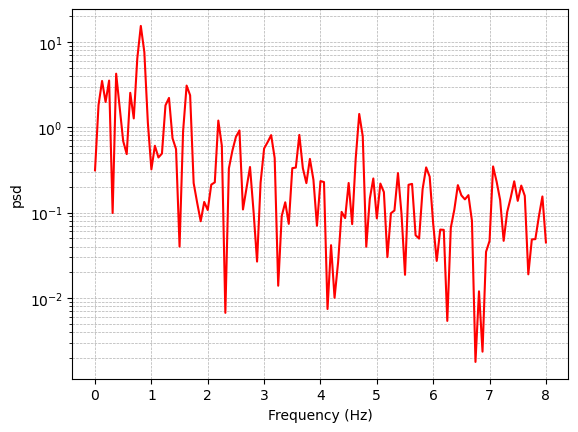

In [93]:
freqs_e_psd_spectrum, auroral_Ehn_disturb_psd_spectrum = welch(Ehn_disturb_auroral, fs_e, scaling='spectrum')

plt.plot(freqs_e_psd_spectrum, auroral_Ehn_disturb_psd_spectrum, color='red')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('psd')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

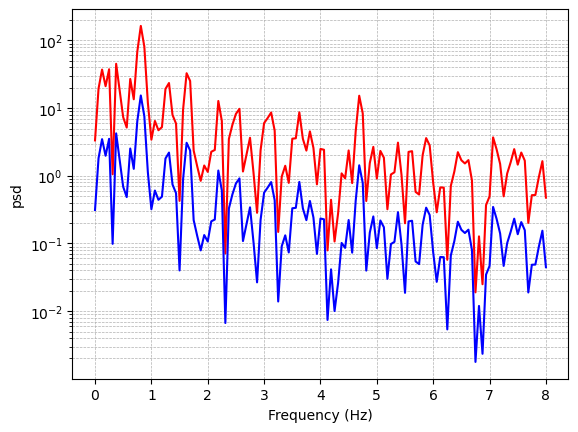

In [94]:
plt.plot(freqs_e_psd_density, auroral_Ehn_disturb_psd_density, color='red')
plt.plot(freqs_e_psd_spectrum, auroral_Ehn_disturb_psd_spectrum, color='blue')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('psd')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()  # note:: 基本上是平移

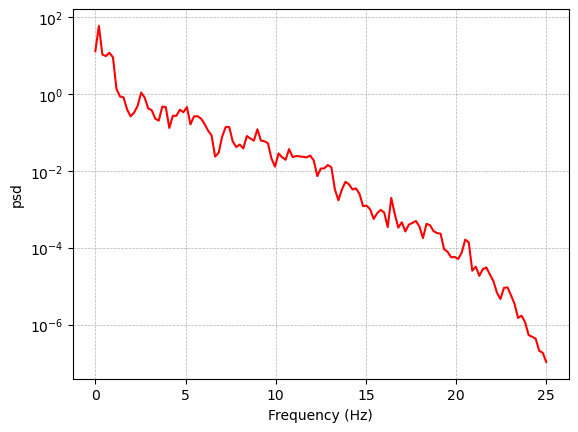

In [95]:
freqs_b_psd_spectrum, auroral_be_disturb_psd_spectrum = welch(be_disturb_auroral, fs_b, scaling='spectrum')

plt.plot(freqs_b_psd_spectrum, auroral_be_disturb_psd_spectrum, color='red')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('psd')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [96]:
# ratio
# todo:: freqs不相同，需要调整welch参数使其相同
mask_b_psd = freqs_b_psd_spectrum < 8
np.all(freqs_e_psd_spectrum)

False

## quiet

In [97]:
quiet_region_start_time = np.datetime64('2016-03-11T06:47:05', 'ns')
quiet_region_end_time = np.datetime64('2016-03-11T06:47:25', 'ns')

In [98]:
quiet_mask = (t_b_dt64 >= quiet_region_start_time) & (t_b_dt64 <= quiet_region_end_time)
quiet_mask

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [99]:
quiet_t_b_dt64 = t_b_dt64[quiet_mask]
quiet_Zxx_b = Zxx_b_mask[:, quiet_mask]
quiet_t_e_dt64 = t_e_dt64[quiet_mask]
quiet_Zxx_e = Zxx_e[:, quiet_mask]

### ratio

In [100]:
quiet_e_b_ratio = np.abs(quiet_Zxx_e) / np.abs(quiet_Zxx_b)
np.max(quiet_e_b_ratio), np.min(quiet_e_b_ratio), np.percentile(quiet_e_b_ratio, 95)

(2212.3737587550695, 0.20998303735288681, 502.51564127120804)

In [101]:
threshold = np.percentile(quiet_e_b_ratio, 95)
set_value = threshold
modified_quiet_e_b_ratio = utils.threshold_and_set(quiet_e_b_ratio.copy(), threshold, set_value)

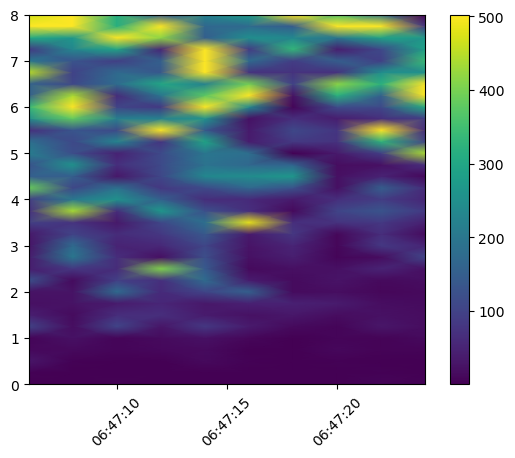

In [102]:
plt.pcolormesh(quiet_t_e_dt64, f_e, modified_quiet_e_b_ratio, shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### counts

In [103]:
np.min(modified_quiet_e_b_ratio), np.max(modified_quiet_e_b_ratio), np.percentile(modified_quiet_e_b_ratio,
                                                                                  50), np.percentile(
    modified_quiet_e_b_ratio, 95)

(0.20998303735288681, 502.51564127120804, 78.85964346218798, 502.5114304437966)

In [104]:
quiet_ratio_bins = np.arange(0, np.max(modified_quiet_e_b_ratio) + 2, 10)  # 这里的值大，所以设置的值大
quiet_ratio_bins

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
       220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
       330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
       440., 450., 460., 470., 480., 490., 500.])

In [105]:
quiet_ratio_hist_counts = utils.get_ratio_histogram2d(f_e, modified_quiet_e_b_ratio, quiet_ratio_bins)

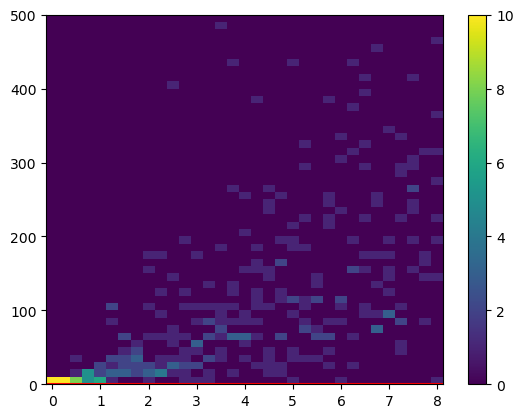

In [106]:
plt.pcolormesh(f_e, (quiet_ratio_bins[:-1] + quiet_ratio_bins[1:]) / 2, quiet_ratio_hist_counts.T)
plt.axhline(1.0, color='red', )
plt.colorbar()
plt.show()  # todo:: 一个频率带内的比值的均值

### phase difference

In [107]:
quiet_cross_e_b_spectral_density_phase_mask = cross_e_b_spectral_density_phase_mask[:, quiet_mask]

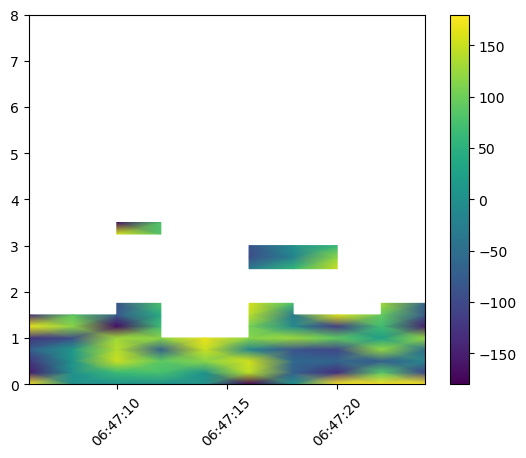

In [108]:
plt.pcolormesh(quiet_t_e_dt64, f_e, quiet_cross_e_b_spectral_density_phase_mask, shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### phase counts

In [109]:
num_bins = 50
phase_diff_bins, quiet_phase_diff_hist_counts = utils.get_phase_histogram2d(f_e,
                                                                            quiet_cross_e_b_spectral_density_phase_mask,
                                                                            num_bins=num_bins)

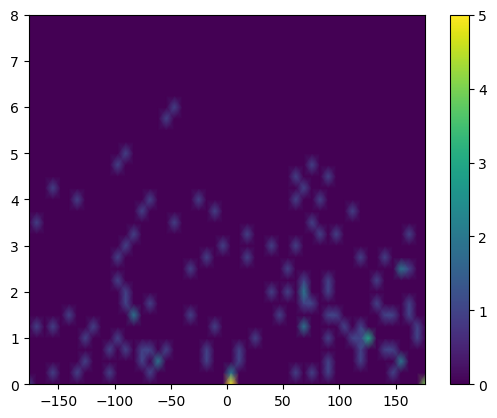

In [110]:
plt.pcolormesh((phase_diff_bins[:-1] + phase_diff_bins[1:]) / 2, f_e, quiet_phase_diff_hist_counts, shading='gouraud')
plt.colorbar()
plt.show()

# cwt

频率范围最大值对应采样频率

## down-resample the MAGx_HR_1B data (50hz)

- 1b 算法文档中提到 vfm 有截止频率大约 9hz？(Swarm Level 1b Processor Algorithms. pdf, page20). so when down-resampling the MAGx_HR_1B magnetic field data to 16hz, don't firstly filter the data?

## original and after filter

几乎没区别，所以磁场数据降采样到16hz（对应的nyquist频率为8hz）不用先进行低通滤波，所以直接使用时间对齐的方式进行降采样，或者直接间隔多少个点取一个点（因为前面的“没区别”，所以这一步不会产生混叠频率？）

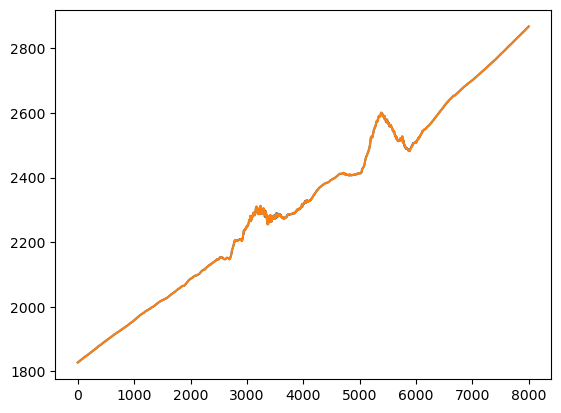

In [111]:
# todo
plt.plot(be)
plt.plot(utils.Butter(be, fs_b).apply_lowpass_filter(8, order))
plt.show()

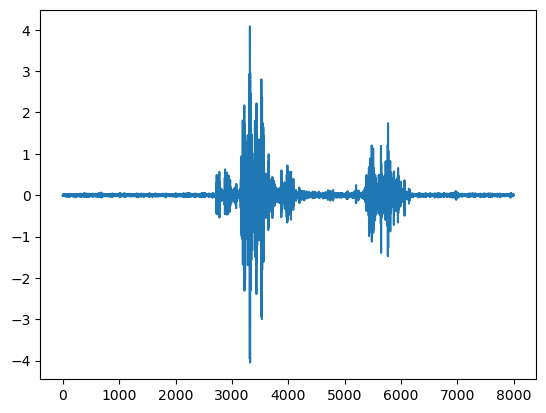

In [112]:
plt.plot(be-utils.Butter(be, fs_b).apply_lowpass_filter(8, order))
plt.show()

## align_high2low

In [113]:
be_align_e = utils.align_high2low(be, timestamps_b, timestamps_e)
# 此后，磁场的对应时间等于电场的对应时间

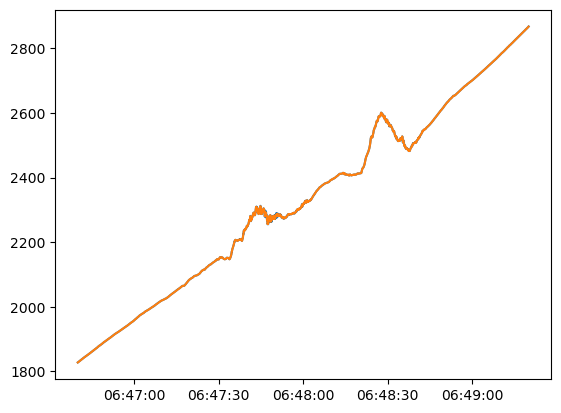

In [114]:
plt.plot(timestamps_b, be)
plt.plot(timestamps_e, be_align_e)
plt.show()

### move average

In [115]:
be_align_e_mov_ave = utils.move_average(be_align_e, window_e)

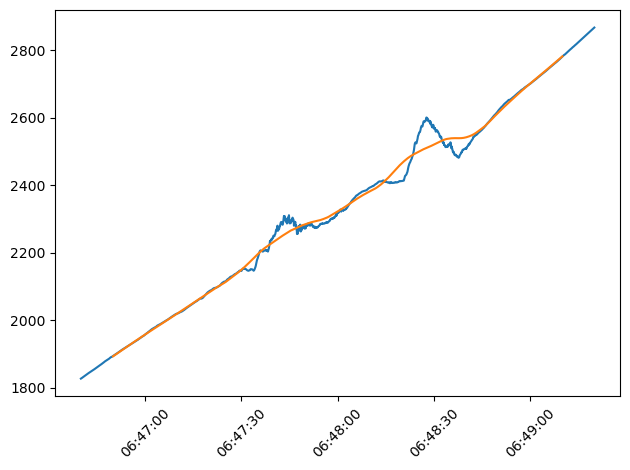

In [116]:
plt.plot(timestamps_e, be_align_e)
plt.plot(timestamps_e, be_align_e_mov_ave)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### disturb field

In [117]:
be_align_e_disturb = be_align_e - be_align_e_mov_ave

In [118]:
be_align_e_disturb_analytical = be_align_e_disturb[mask_e]

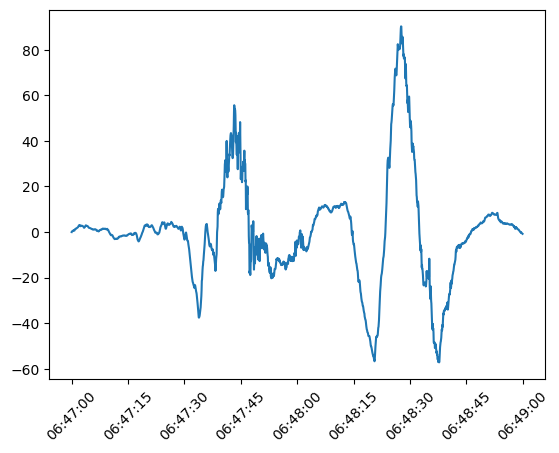

In [119]:
plt.plot(timestamps_e_analytical, be_align_e_disturb_analytical)
plt.xticks(rotation=45)
plt.show()

### cwt

In [120]:
cwt_b_e = utils.CWT(be_align_e_disturb_analytical,Ehn_disturb_analytical)
cwt_b_e_cross_spectrum_modulus, cwt_b_e_cross_phase, cwt_b_e_freqs = cwt_b_e.get_cross_spectral()

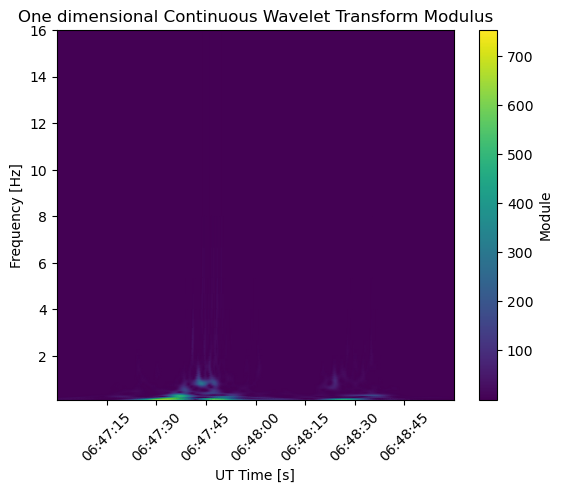

In [121]:
plt.pcolormesh(timestamps_e_analytical,cwt_b_e_freqs,cwt_b_e_cross_spectrum_modulus,shading='gouraud')
plt.colorbar(label='Module')
plt.xticks(rotation=45)
plt.xlabel('UT Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('One dimensional Continuous Wavelet Transform Modulus')
plt.show()

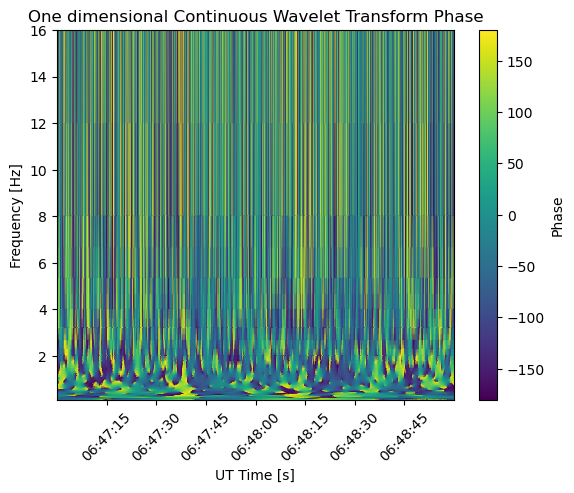

In [122]:
plt.pcolormesh(timestamps_e_analytical,cwt_b_e_freqs,cwt_b_e_cross_phase,shading='gouraud')
plt.colorbar(label='Phase')
plt.xticks(rotation=45)
plt.xlabel('UT Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('One dimensional Continuous Wavelet Transform Phase')
plt.show()

In [123]:
cwt_b_e_cross_phase_bins, cwt_b_e_cross_phase_hist_counts = utils.get_phase_histogram2d(cwt_b_e_freqs, cwt_b_e_cross_phase, 50)

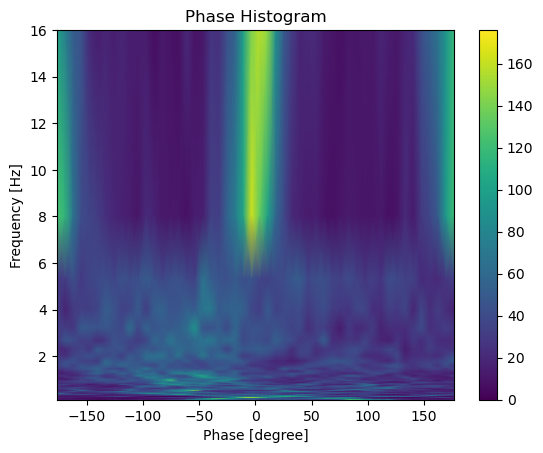

In [124]:
plt.pcolormesh((cwt_b_e_cross_phase_bins[:-1] + cwt_b_e_cross_phase_bins[1:]) / 2, cwt_b_e_freqs, cwt_b_e_cross_phase_hist_counts, shading='gouraud')
plt.colorbar()
plt.xlabel('Phase [degree]')
plt.ylabel('Frequency [Hz]')
plt.title('Phase Histogram')
plt.show()

#### auroral region

In [125]:
be_align_e_disturb_auroral = be_align_e_disturb_analytical[mask_e_auroral]

In [126]:
cwt_b_e_auroral = utils.CWT(be_align_e_disturb_auroral, Ehn_disturb_auroral)
cwt_b_e_cross_spectrum_modulus_auroral, cwt_b_e_cross_phase_auroral, cwt_b_e_freqs_auroral = cwt_b_e_auroral.get_cross_spectral()

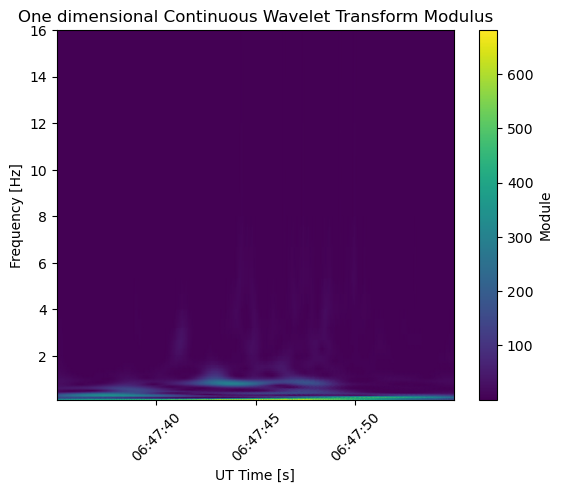

In [127]:
plt.pcolormesh(timestamps_e_auroral, cwt_b_e_freqs_auroral, cwt_b_e_cross_spectrum_modulus_auroral, shading='gouraud')
plt.colorbar(label='Module')
plt.xticks(rotation=45)
plt.xlabel('UT Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('One dimensional Continuous Wavelet Transform Modulus')
plt.show()

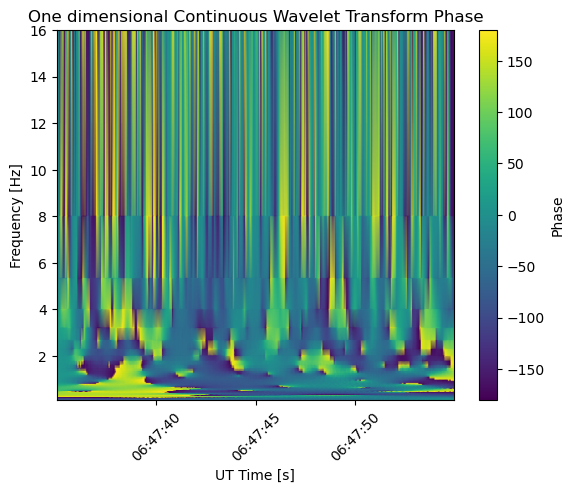

In [128]:
plt.pcolormesh(timestamps_e_auroral, cwt_b_e_freqs_auroral, cwt_b_e_cross_phase_auroral, shading='gouraud')
plt.colorbar(label='Phase')
plt.xticks(rotation=45)
plt.xlabel('UT Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('One dimensional Continuous Wavelet Transform Phase')
plt.show()

显示方法的不同，导致结果图像不同，使用`pcolormesh()`更合理，因为输入的数据是一一对应的，而`imshow()`中的`extend`并不对应输入的`hist_counts`（但是，其显示的图像能明显地看出规律，前者不行）

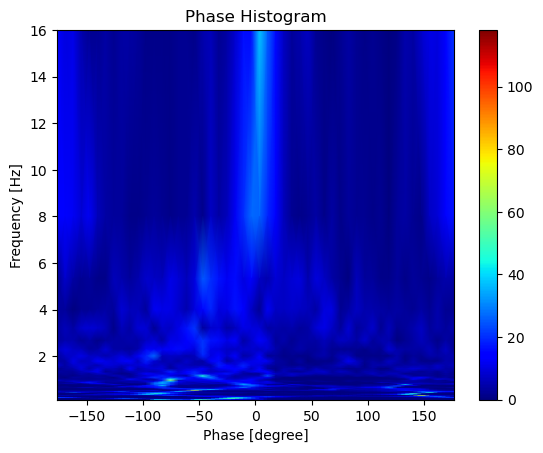

In [129]:
cwt_b_e_cross_phase_bins_auroral, cwt_b_e_cross_phase_hist_counts_auroral = utils.get_phase_histogram2d(cwt_b_e_freqs_auroral, cwt_b_e_cross_phase_auroral, 50)

plt.pcolormesh((cwt_b_e_cross_phase_bins_auroral[:-1] + cwt_b_e_cross_phase_bins_auroral[1:]) / 2, cwt_b_e_freqs_auroral, cwt_b_e_cross_phase_hist_counts_auroral, shading='gouraud',cmap='jet')
plt.colorbar()
plt.xlabel('Phase [degree]')
plt.ylabel('Frequency [Hz]')
plt.title('Phase Histogram')
plt.show()

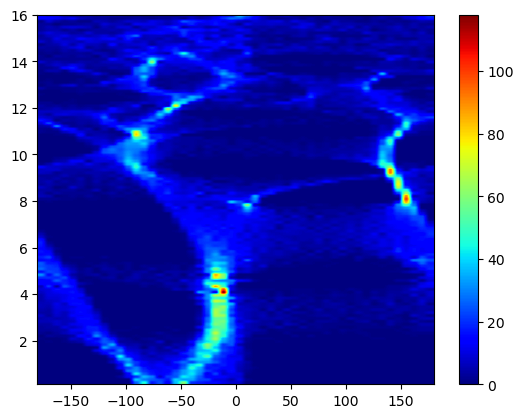

In [130]:
plt.imshow(cwt_b_e_cross_phase_hist_counts_auroral, extent=[-180, 180, cwt_b_e_freqs_auroral[-1], cwt_b_e_freqs_auroral[0]], aspect='auto', cmap='jet')
plt.colorbar()
plt.show()

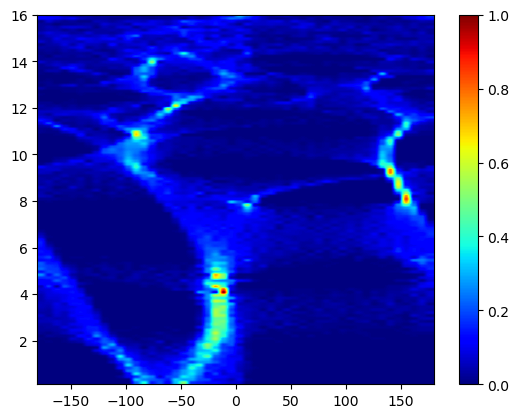

In [131]:
# 用所有频率对应的hist_count的最大值对该频率的hist_count进行正则化，受所有频率的相位差的影响。
plt.imshow(utils.normalize_to_01(cwt_b_e_cross_phase_hist_counts_auroral), extent=[-180, 180, cwt_b_e_freqs_auroral[-1], cwt_b_e_freqs_auroral[0]], aspect='auto', cmap='jet')
plt.colorbar()
plt.show()

In [132]:
# 用每一个频率对应的hist_count的最大值对该频率的hist_count进行正则化，关心每个频率的相位差的独立分布，而不受所有频率的相位差的影响。
cwt_b_e_cross_phase_hist_counts_auroral_normalized = cwt_b_e_cross_phase_hist_counts_auroral / np.max(cwt_b_e_cross_phase_hist_counts_auroral,axis=1,keepdims=True)  # todo:: function

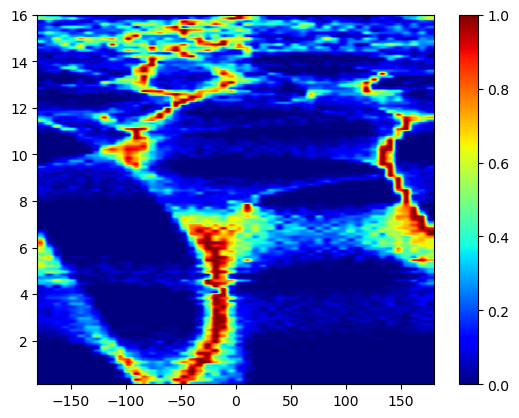

In [133]:
plt.imshow(cwt_b_e_cross_phase_hist_counts_auroral_normalized, extent=[-180, 180, cwt_b_e_freqs_auroral[-1], cwt_b_e_freqs_auroral[0]], aspect='auto', cmap='jet')
plt.colorbar()
plt.show()

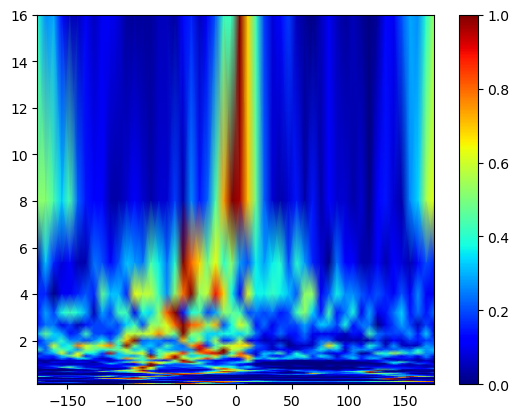

In [134]:
plt.pcolormesh((cwt_b_e_cross_phase_bins_auroral[:-1] + cwt_b_e_cross_phase_bins_auroral[1:]) / 2, cwt_b_e_freqs_auroral, cwt_b_e_cross_phase_hist_counts_auroral_normalized, shading='gouraud',cmap='jet')
plt.colorbar()
plt.show()

# plot

NameError: name 'cwt21' is not defined

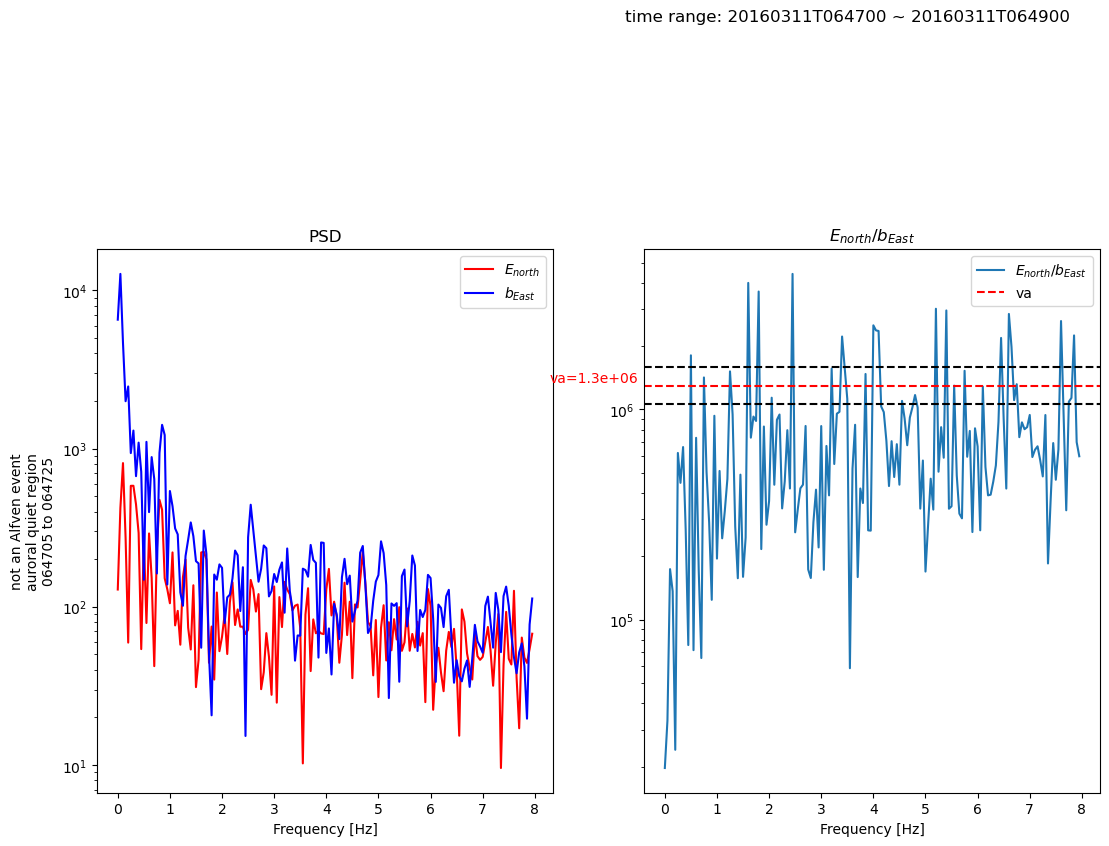

In [132]:
# signal1 = signal1_back
# signal2 = signal2_align_back
# start = pd.to_datetime('20160311T064705')
# end = pd.to_datetime('20160311T064725')
# signal1 = signal1.loc[start:end]
# signal2 = signal2.loc[start:end]
# cwt21 = utils_spectral.CWT(signal1, signal2, sampling_period=1 / 16)


plt.figure(figsize=(20,24))
plt.suptitle('time range: 20160311T064700 ~ 20160311T064900')
# f1
# assert all(signal1.index == signal2.index), "signal1 and signal2 must have the same index"
# psd1 = utils_spectral.PSD(signal1, 16)
# psd2 = utils_spectral.PSD(signal2, 16)
# freqs1, Pxx1 = psd1.get_psd()
# freqs2, Pxx2 = psd2.get_psd()
# assert all(freqs_e_psd_density == freqs2), "freqs1 and freqs2 must be equal"
# x = freqs1
# y1 = np.sqrt(Pxx1)
# y2 = np.sqrt(Pxx2)
plt.subplot(331)
plt.plot(freqs_e, amps_e, color='red', label=r'$E_{north}$')
plt.plot(freqs_b_mask, amps_b_mask, color='blue', label=r'$b_{East}$')
# plt.xlim([0,8])
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('not an Alfven event\nauroral quiet region\n064705 to 064725')
plt.title('PSD')  # todo:: spectrum


# x = freqs1
# y = np.sqrt(Pxx1 / Pxx2) * 1e6
plt.subplot(332)
plt.plot(freqs_e, eb_ratio_fft_SI, label=r'$E_{north}$/$b_{East}$')
# plt.xlim([0,8])
plt.axhline(y=va_quiet, color='red', linestyle='--', linewidth=1.5, label='va')
plt.axhline(y=1/(mu0 * Sigma_P_quiet), color='black', linestyle='--', linewidth=1.5,label='_')
plt.axhline(y=(mu0 * va_quiet ** 2 * Sigma_P_quiet), color='black', linestyle='--', linewidth=1.5, label='_')
# Add annotation for the horizontal line
plt.text(x=-0.5, y=va_quiet, s=f'va={va_quiet:.1e}', color='red', verticalalignment='bottom', horizontalalignment='right')
# plt.text(x=-0.5, y=1/(mu0 * Sigma_P_quiet), s=r'$\Sigma_P^{-1}$', color='red', verticalalignment='bottom', horizontalalignment='right')
# plt.text(x=-0.5, y=(mu0 * va_quiet ** 2 * Sigma_P_quiet), s=r'$Z_A^2 \Sigma_P$', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.title(r'$E_{north}$/$b_{East}$')
plt.legend()

hist_counts, freqs = cwt21.get_phase_histogram2d()
plt.subplot(333)
plt.imshow(hist_counts, extent=[-180, 180,freqs[-1], freqs[0]], aspect='auto', cmap='jet')
plt.ylim([0,8])
# plt.colorbar(label='Normalized Counts')
plt.xlabel('Phase [degree]')
plt.ylabel('Frequency [Hz]')
plt.title('Phase Histogram')


###
signal1 = signal1_back
signal2 = signal2_align_back
start = pd.to_datetime('20160311T064735')
end = pd.to_datetime('20160311T064755')
signal1 = signal1.loc[start:end]
signal2 = signal2.loc[start:end]
cwt21 = utils_spectral.CWT(signal1, signal2, sampling_period=1 / 16)


# f4
assert all(signal1.index == signal2.index), "signal1 and signal2 must have the same index"
psd1 = utils_spectral.PSD(signal1, 16)
psd2 = utils_spectral.PSD(signal2, 16)
freqs1, Pxx1 = psd1.get_psd()
freqs2, Pxx2 = psd2.get_psd()
assert all(freqs1 == freqs2), "freqs1 and freqs2 must be equal"
x = freqs1
y1 = np.sqrt(Pxx1)
y2 = np.sqrt(Pxx2)
plt.subplot(334)
plt.plot(x, y1, label=r'$E_{north}$')
plt.plot(x, y2, label=r'$b_{East}$')
plt.xlim([0,8])
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('an Alfven event\nauroral dynamic region\n064735 to 064755')
plt.title('PSD')


x = freqs1
y = np.sqrt(Pxx1 / Pxx2) * 1e6
plt.subplot(335)
plt.plot(x, y, label=r'$E_{north}$/$b_{East}$')
plt.xlim([0,8])
plt.axhline(y=va_auroral, color='red', linestyle='--', linewidth=1.5, label='va')
plt.axhline(y=1/(mu0 * Sigma_P_auroral), color='black', linestyle='--', linewidth=1.5,label='_')
plt.axhline(y=(mu0 * va_auroral ** 2 * Sigma_P_auroral), color='black', linestyle='--', linewidth=1.5, label='_')
# Add annotation for the horizontal line
plt.text(x=1, y=va_auroral, s=f'va={va_auroral:.1e}', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(x=1, y=1/(mu0 * Sigma_P_auroral), s=r'$\Sigma_P^{-1}$', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(x=1, y=(mu0 * va_auroral ** 2 * Sigma_P_auroral), s=r'$Z_A^2 \Sigma_P$', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.title(r'$E_{north}$/$b_{East}$')
plt.legend()

hist_counts, freqs = cwt21.get_phase_histogram2d()
plt.subplot(336)
plt.imshow(hist_counts, extent=[-180, 180,freqs[-1], freqs[0]], aspect='auto', cmap='jet')
plt.ylim([0,8])
# plt.colorbar(label='Normalized Counts')
plt.xlabel('Phase [degree]')
plt.ylabel('Frequency [Hz]')
plt.title('Phase Histogram')


###
signal1 = signal1_back
signal2 = signal2_align_back
start = pd.to_datetime('20160311T064820')
end = pd.to_datetime('20160311T064840')
signal1 = signal1.loc[start:end]
signal2 = signal2.loc[start:end]
cwt21 = utils_spectral.CWT(signal1, signal2, sampling_period=1 / 16)


# f4
assert all(signal1.index == signal2.index), "signal1 and signal2 must have the same index"
psd1 = utils_spectral.PSD(signal1, 16)
psd2 = utils_spectral.PSD(signal2, 16)
freqs1, Pxx1 = psd1.get_psd()
freqs2, Pxx2 = psd2.get_psd()
assert all(freqs1 == freqs2), "freqs1 and freqs2 must be equal"
x = freqs1
y1 = np.sqrt(Pxx1)
y2 = np.sqrt(Pxx2)
plt.subplot(337)
plt.plot(x, y1, label=r'$E_{north}$')
plt.plot(x, y2, label=r'$b_{East}$')
plt.xlim([0,8])
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('an Alfven event\nauroral dynamic region\n064820 to 064840')
plt.title('PSD')


x = freqs1
y = np.sqrt(Pxx1 / Pxx2) * 1e6
plt.subplot(338)
plt.plot(x, y, label=r'$E_{north}$/$b_{East}$')
plt.xlim([0,8])
plt.axhline(y=va_auroral, color='red', linestyle='--', linewidth=1.5, label='va')
plt.axhline(y=1/(mu0 * Sigma_P_auroral), color='black', linestyle='--', linewidth=1.5,label='_')
plt.axhline(y=(mu0 * va_auroral ** 2 * Sigma_P_auroral), color='black', linestyle='--', linewidth=1.5, label='_')
# Add annotation for the horizontal line
plt.text(x=1, y=va_auroral, s=f'va={va_auroral:.1e}', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(x=1, y=1/(mu0 * Sigma_P_auroral), s=r'$\Sigma_P^{-1}$', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(x=1, y=(mu0 * va_auroral ** 2 * Sigma_P_auroral), s=r'$Z_A^2 \Sigma_P$', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.title(r'$E_{north}$/$b_{East}$')
plt.legend()

hist_counts, freqs = cwt21.get_phase_histogram2d()
plt.subplot(339)
plt.imshow(hist_counts, extent=[-180, 180,freqs[-1], freqs[0]], aspect='auto', cmap='jet')
plt.ylim([0,8])
# plt.colorbar(label='Normalized Counts')
plt.xlabel('Phase [degree]')
plt.ylabel('Frequency [Hz]')
plt.title('Phase Histogram')


#
# swarm.figure_psd(signal1, signal2, 16)
# swarm.figure_ratio(signal1, signal2, 16)
# cwt = utils_spectral.CWT(signal1, signal2,sampling_period=1/16)